In [1]:
from Methods.Adams import adams
from Methods.Euler import euler
from Methods.AdamsBashfortMoulton import abm
from Methods.PredictorCorrector import predictor_corrector as pred_corr
from Methods.RungeKutt import rk_a,rk_b
from Methods.Gir import gir
import numpy as np
from matplotlib import pyplot as plt
from Method import Method
import pandas as pd
from math import log
def fi(x):
    return np.sin(np.exp(np.power(x,2)))


def dfi(x):
    return 2 * np.exp(np.power(x,2))*x * np.cos(np.exp(np.power(x,2)))


def f(x, y):
    return dfi(x) + k * (y - fi(x))


def fi_m(x, initial_y, f):
    #print('called')
    return fi(x)

def runge_rule(p,yh_2,yh):
    _yh_2 = np.zeros(yh_2.shape[0]*2)
    for i in range(yh_2.shape[0]):
        _yh_2[2*i] = yh_2[i]
        _yh_2[2*i+1] = yh_2[i]
    return np.max((1/(2**p -1) ) * np.abs((_yh_2 - yh)))

def compare(y1,y2):
    n = y1
    eps_global = np.abs(y1 - y2) 
    eps_local = eps_global / np.maximum(np.abs(y1),np.abs(y2))
    eps_max = np.max(eps_global)
    return eps_global,eps_local,eps_max

In [2]:
N = 5 * 2 ** 1
_N = 5 * 2 ** 6
k = 2.5
x0 = -1.5
xN = 1.5

In [3]:
fi_method = Method(x0,xN,0,N,fi_m,1, name = 'Исходная функция')
euler_method = Method(x0,xN,k,N,euler,1, name = 'явный метод Эйлера', y_num_to_start = 1)
adams_method = Method(x0,xN,k,N,adams,4, name = 'явный метод Адамса', y_num_to_start = 4)
pc_method = Method(x0,xN,k,N,pred_corr,2, name = 'метод типа предиктор-корректор', is_iter = True, _lambda = 0.01, y_num_to_start = 1)
abm_method = Method(x0,xN,k,N,abm,4, name = 'метод Адамса-Бэшфорта-Моултона', y_num_to_start = 4, starter = fi_method)
rka_method = Method(x0,xN,k,N,rk_a,3, name = 'метод Рунге-Кутты O(h^3)', y_num_to_start = 1)
rkb_method = Method(x0,xN,k,N,rk_b,4, name = 'метод Рунге-Кутты O(h^4)', y_num_to_start = 1)
gir_method = Method(x0,xN,k,N,gir,4,require_additional = True, fi = fi,dfi= dfi, name = 'метод Гира', y_num_to_start = 4)

euler_method.starter = fi_method
adams_method.starter = rkb_method
pc_method.starter = fi_method
abm_method.starter = rkb_method
rka_method.starter =  fi_method
rkb_method.starter = fi_method
gir_method.starter = rkb_method

methods = [euler_method,adams_method,pc_method,abm_method,rka_method,rkb_method,gir_method]
method_count = len(methods)

In [4]:
n_s = [10,200,1000,10000]


calculation_results = []
for current_n in n_s:
    tmp = []
    nodes = np.linspace(x0, xN, current_n)
    for method in methods:
        y = method.calculate(fi(nodes)[:4],f, N = current_n )
        
        tmp.append(y)
    calculation_results.append(tmp)
  
y_fi = fi(nodes)


0.01
0.01
0.01


KeyboardInterrupt: 

In [ ]:
subplots = []
fig, subplots = plt.subplots(len(n_s),figsize=(6.5,3*len(n_s)))

title = '1.Сравнение всех методов на разных N при k= ' +str(k)+'.'
fig.suptitle(title, fontsize=16)


nodes_draw = np.linspace(x0, xN, _N)

for sublot_num in range(len(subplots)):
    nodes = np.linspace(x0, xN, n_s[sublot_num])
    subplot = subplots[sublot_num]
    subplot.set_title('N = '+str(n_s[sublot_num]),fontsize=13)
    subplot.plot(nodes_draw, fi(nodes_draw), label='Исходная функция φ(x)', linewidth=4)
    for i in range(method_count):
        subplot.plot(nodes, calculation_results[sublot_num][i], label=str(methods[i].name), linewidth=2)
                     
line_labels = ["Исходная функция φ(x)"]+[m.name for m in methods]
#ax1.legend(loc='lower left')
fig.legend(line_labels,     # The line objects
              # The labels for each line
           loc="lower center",   # Position of legend
           borderaxespad=0.5,    # Small spacing around legend box
           title="Методы",  # Title for the legend
           framealpha=1
           )
fig.savefig('images/graph1.png',dpi = 200)

In [5]:
def calculate_real_p(eps):
    
    n,m = eps.shape
    result = np.zeros((n,m-1))
    for i in range(n):
        for j in range(m-1):
             result[i,j] = log( \
                                abs( eps[i,j] / eps[i,j+1] )\
                                ) / log(2)
    return result

In [22]:


iteration_count = 18
pc_method._lambda = 1e+1
N_test =( 5 * (2**np.linspace(0,iteration_count-1,iteration_count))).astype('int32') 

result = np.zeros((method_count,iteration_count ))
calculations = [[] for i in range(method_count)]
i = -1

for n in N_test:
    i+=1
    nodes = np.linspace(x0,xN,n)
    y_fi = fi(nodes)
    j = -1
    for method in methods:
        j+=1
        y_method = method.calculate(y_fi[:4],f, N = n )
        calculations[j].append(y_method)
        _,_,eps = compare(y_fi,y_method)
        result[j,i] = eps
        print(i,j)

        
methods_names = [m.name for m in methods]
err_df = pd.DataFrame(result, index=methods_names, columns=list(N_test))


p_calculated = calculate_real_p(result)
        
p_calculated_real = np.concatenate([p_calculated, np.zeros((method_count,1))], axis = 1)

for method_num in range(method_count):
    p_calculated_real[method_num,iteration_count-1] = methods[method_num].p

p_calculated_df = pd.DataFrame(p_calculated_real, index=methods_names, columns=list(N_test)[:-1] +['p'] )

0 0
0 1
0 2
0 3
0 4
0 5
0 6
1 0
1 1
1 2
1 3
1 4
1 5
1 6
2 0
2 1
2 2
2 3
2 4
2 5
2 6
3 0
3 1
3 2
3 3
3 4
3 5
3 6
4 0
4 1
4 2
4 3
4 4
4 5
4 6
5 0
5 1
5 2
5 3
5 4
5 5
5 6
6 0
6 1
6 2
6 3
6 4
6 5
6 6
7 0
7 1
7 2
7 3
7 4
7 5
7 6
8 0
8 1
8 2
8 3
8 4
8 5
8 6
9 0
9 1
9 2
9 3
9 4
9 5
9 6
10 0
10 1
10 2
10 3
10 4
10 5
10 6
11 0
11 1
11 2
11 3
11 4
11 5
11 6
12 0
12 1
12 2
12 3
12 4
12 5
12 6
13 0
13 1
13 2
13 3
13 4
13 5
13 6
14 0
14 1
14 2
14 3
14 4
14 5
14 6
15 0
15 1
15 2
15 3
15 4
15 5
15 6
16 0
16 1
16 2
16 3
16 4
16 5
16 6
17 0
17 1
17 2
17 3
17 4
17 5
17 6


In [27]:
i = -1
for n in N_test:
    i+=1
    j = -1
    for method in methods:
        j+=1
        np.savetxt('calculations/calc%d.%d.out'%(j,i), calculations[j][i], delimiter=',')

In [75]:
relative_err = np.zeros((method_count,iteration_count - 1))

for iteration in range(iteration_count-1):
    for method_num in range(method_count): 
        k = calculations[method_num][iteration].shape[0]
        y = np.zeros(2*k)
        for i in range(0,k):
           y[2*i] =  calculations[method_num][iteration+1][i]
        
        for i in range(k-1):
           y[2*i + 1] =  (y[2*i] + y[2*i+2])/2
        y[2*k - 1] = y[2*k -2]
        _,tmp,_ = compare(y,calculations[method_num][iteration+1])
        relative_err[method_num,iteration] = max(tmp)
relative_err_df = pd.DataFrame(relative_err, index=methods_names, columns=list(N_test[:-1]) )
relative_err_df

,5,10,20,40,80,160,320,640,1280,2560,5120,10240
явный метод Эйлера,9.51e-01,9.64e-01,9.69e-01,1.00e+00,1.87e+00,1.98e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00
явный метод Адамса,1.66e+00,9.81e-01,1.68e+00,1.92e+00,1.95e+00,1.99e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00
метод типа предиктор-корректор,9.80e-01,9.79e-01,1.90e+00,1.91e+00,1.95e+00,1.99e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00
метод Адамса-Бэшфорта-Моултона,1.82e+00,9.82e-01,1.80e+00,1.94e+00,1.99e+00,2.00e+00,1.99e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00
метод Рунге-Кутты O(h^3),1.01e+00,1.03e+00,1.91e+00,2.00e+00,1.99e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00
метод Рунге-Кутты O(h^4),1.66e+00,9.83e-01,1.90e+00,1.95e+00,1.99e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00
метод Гира,1.66e+00,1.68e+00,1.73e+00,1.99e+00,1.97e+00,1.99e+00,1.99e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00,2.00e+00


In [16]:
pd.options.display.float_format = '{:.2e}'.format
err_df.to_csv('err2.csv')
err_df

,5,10,20,40,80,160,320,640,1280,2560,5120,10240,20480,40960,81920,163840,327680,655360
явный метод Эйлера,4.86e+02,1.34e+03,1.34e+03,9.58e+02,6.51e+02,3.89e+02,2.13e+02,1.12e+02,5.73e+01,2.90e+01,1.46e+01,7.32e+00,3.67e+00,1.83e+00,9.17e-01,4.59e-01,2.29e-01,1.15e-01
явный метод Адамса,5.55e+03,9.15e+01,2.82e+03,1.36e+02,2.89e+02,3.36e+01,2.33e+00,1.41e-01,8.42e-03,5.09e-04,3.12e-05,1.93e-06,1.20e-07,7.46e-09,4.61e-10,3.95e-11,1.23e-11,6.24e-12
метод типа предиктор-корректор,9.13e+03,9.25e+03,1.62e+03,7.71e+01,2.38e+00,3.85e-01,1.69e-01,4.87e-02,1.28e-02,3.28e-03,8.27e-04,2.08e-04,5.21e-05,1.30e-05,3.26e-06,8.14e-07,2.05e-07,5.41e-08
метод Адамса-Бэшфорта-Моултона,6.80e+03,2.76e+01,7.25e+02,5.23e+01,2.78e+00,1.55e+00,1.58e-01,1.05e-02,6.41e-04,3.88e-05,2.37e-06,1.46e-07,9.27e-09,7.06e-10,2.87e-10,1.52e-09,1.28e-09,3.15e-09
метод Рунге-Кутты O(h^3),5.52e+03,4.49e+02,2.98e+02,1.34e+01,2.90e-01,2.89e-02,7.26e-03,1.13e-03,1.55e-04,2.02e-05,2.57e-06,3.25e-07,4.06e-08,4.97e-09,9.62e-10,1.60e-09,1.27e-09,3.15e-09
метод Рунге-Кутты O(h^4),7.49e+03,1.12e+01,3.63e+02,1.89e+01,9.56e-01,5.56e-02,3.39e-03,2.10e-04,1.31e-05,8.15e-07,5.09e-08,3.26e-09,3.98e-10,1.56e-10,3.17e-10,1.52e-09,1.28e-09,3.15e-09
метод Гира,2.04e+04,1.17e+02,1.26e+02,2.75e+02,1.02e+02,1.75e+01,1.34e+00,8.26e-02,4.91e-03,2.95e-04,1.80e-05,1.11e-06,6.90e-08,4.01e-09,1.27e-10,2.09e-09,3.32e-09,1.36e-10


In [18]:
calculations
runge_errors = np.zeros((method_count,iteration_count-1))
for method_num in range(method_count):
    for iteration in range(iteration_count-1):
        runge_errors[method_num,iteration] = runge_rule(methods[method_num].p,calculations[method_num][iteration],calculations[method_num][iteration+1])
runge_df = pd.DataFrame(runge_errors, index=methods_names, columns=list(N_test[:-1]) )
runge_df.to_csv("runge.csv")
runge_df

,5,10,20,40,80,160,320,640,1280,2560,5120,10240,20480,40960,81920,163840,327680
явный метод Эйлера,8.59e+02,3.86e+02,5.36e+02,3.63e+02,2.80e+02,1.80e+02,1.03e+02,5.49e+01,2.84e+01,1.44e+01,7.28e+00,3.65e+00,1.83e+00,9.17e-01,4.59e-01,2.29e-01,1.15e-01
явный метод Адамса,3.76e+02,1.82e+02,1.97e+02,1.02e+01,1.71e+01,2.08e+00,1.46e-01,9.12e-03,2.22e-03,1.11e-03,5.55e-04,2.77e-04,1.39e-04,6.94e-05,3.47e-05,1.73e-05,8.67e-06
метод типа предиктор-корректор,1.72e+03,2.72e+03,5.18e+02,2.49e+01,9.22e-01,1.60e-01,8.44e-02,3.41e-02,1.43e-02,6.36e-03,2.98e-03,1.44e-03,7.07e-04,3.50e-04,1.74e-04,8.69e-05,4.34e-05
метод Адамса-Бэшфорта-Моултона,4.55e+02,4.65e+01,5.18e+01,3.30e+00,2.89e-01,1.11e-01,1.87e-02,5.09e-03,2.26e-03,1.11e-03,5.55e-04,2.77e-04,1.39e-04,6.94e-05,3.47e-05,1.73e-05,8.67e-06
метод Рунге-Кутты O(h^3),7.61e+02,1.07e+02,4.12e+01,2.01e+00,1.17e-01,3.74e-02,1.89e-02,9.49e-03,4.75e-03,2.38e-03,1.19e-03,5.94e-04,2.97e-04,1.49e-04,7.43e-05,3.72e-05,1.86e-05
метод Рунге-Кутты O(h^4),4.99e+02,2.49e+01,2.32e+01,1.26e+00,9.38e-02,2.09e-02,9.04e-03,4.44e-03,2.22e-03,1.11e-03,5.55e-04,2.77e-04,1.39e-04,6.94e-05,3.47e-05,1.73e-05,8.67e-06
метод Гира,1.37e+03,1.62e+01,9.90e+00,2.51e+01,5.70e+00,1.10e+00,9.26e-02,9.61e-03,2.52e-03,1.13e-03,5.56e-04,2.77e-04,1.39e-04,6.94e-05,3.47e-05,1.73e-05,8.67e-06


In [28]:
err_df = pd.read_csv("err.csv", header = 0, index_col = 0)
err_df

,5,10,20,40,80,160,320,640,1280,2560,5120,10240,20480,40960,81920,163840,327680,655360
явный метод Эйлера,485.868824,1344.615255,1339.139422,958.232241,651.286679,388.843530,213.435689,111.930004,57.329411,2.901375e+01,1.459514e+01,7.319766e+00,3.665448e+00,1.834117e+00,9.174070e-01,4.587907e-01,2.294171e-01,1.147140e-01
явный метод Адамса,5550.162450,91.482123,2820.941850,136.166043,288.688443,33.561510,2.330120,0.141158,0.008417,5.085432e-04,3.115614e-05,1.926323e-06,1.197078e-07,7.457380e-09,4.610328e-10,3.954619e-11,1.228823e-11,6.236539e-12
метод типа предиктор-корректор,2867.537156,5474.043907,1713.383114,218.326475,42.967712,10.224912,2.535137,0.633559,0.158506,3.964968e-02,9.915878e-03,2.479436e-03,6.199192e-04,1.549874e-04,3.874817e-05,9.688604e-06,2.420505e-06,6.022990e-07
метод Адамса-Бэшфорта-Моултона,6802.759373,27.583963,724.937190,52.317622,2.775650,1.552245,0.157998,0.010538,0.000641,3.878316e-05,2.369975e-06,1.463071e-07,9.274129e-09,7.055038e-10,2.867475e-10,1.519063e-09,1.277812e-09,3.154000e-09
метод Рунге-Кутты O(h^3),5519.976008,448.784278,298.331083,13.427770,0.289520,0.028879,0.007264,0.001128,0.000155,2.016568e-05,2.573279e-06,3.248520e-07,4.062096e-08,4.971280e-09,9.615365e-10,1.599315e-09,1.268176e-09,3.153157e-09
метод Рунге-Кутты O(h^4),7485.727673,11.186214,362.694814,18.881271,0.956200,0.055579,0.003389,0.000210,0.000013,8.149532e-07,5.086979e-08,3.262522e-09,3.982803e-10,1.556843e-10,3.167535e-10,1.519943e-09,1.277565e-09,3.154199e-09
метод Гира,20373.842508,117.294105,126.122593,274.571953,101.766548,17.507456,1.338402,0.082592,0.004909,2.947958e-04,1.797799e-05,1.108739e-06,6.903157e-08,4.011240e-09,1.274552e-10,2.085860e-09,3.322450e-09,1.355418e-10


[<Method.Method object at 0x1187197d0>, <Method.Method object at 0x118719550>, <Method.Method object at 0x1171bad50>, <Method.Method object at 0x118719ad0>, <Method.Method object at 0x11272e550>, <Method.Method object at 0x1171ba590>, <Method.Method object at 0x1171ba250>]


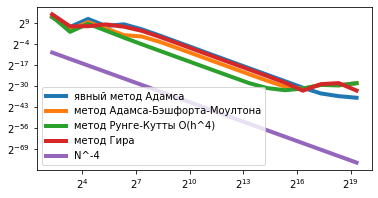

In [45]:
#method_err_plot = gir_method
p_draw = 4

fig = plt.figure(figsize=(6,3))
plt.yscale('log',basey=2) 
plt.xscale('log',basex=2) 
print(methods
     )
for method in methods:
    if not method.p == p_draw:
        continue
    row = err_df.loc[method.name]
    size = row.shape[0]
    err = [row.iloc[i] for i in range(size)]
    plt.plot(N_test,err,  label=method.name, linewidth=4) 
    
plt.plot(N_test,np.power(N_test.astype('float32'),-p_draw),label = 'N^-'+str(p_draw), linewidth=4) 
plt.legend(loc='lower left')

plt.savefig('images/ERR'+str(p_draw)+'.png',dpi = 200)

In [10]:
pd.options.display.float_format = '{:.2f}'.format
p_calculated_df.to_csv('dam.csv')

In [7]:
test_method = adams_method
iteration_count = 1
N_test = [80* 1** i for i in range(iteration_count)]
err = np.zeros((method_count-1,iteration_count))
methods_names = []
for j in range(iteration_count):
        n = N_test[j]
        nodes = np.linspace(x0,xN,n)
        y_fi = fi(nodes)
        i = -1
        for method in methods:
            if method == test_method:
                continue    
            i+=1
            if j == 0:
                methods_names.append(method.name)
            test_method.starter = method
            y_method = test_method.calculate([],f, N = n )
            _,_,eps = compare(y_fi,y_method)
            err[i,j] = eps
        
print(methods_names)
p = calculate_real_p(err)
p_df = pd.DataFrame(p, index=methods_names, columns=list(N_test)[:-1] )
p_df.to_csv("change1.csv")

[]
[-0.06291629]
[-0.06291629  1.01582357  1.58560233  1.43642205]
[]
[-0.06291629]
[-0.06291629  0.76134302  0.9463359   0.54451421]
[]
[-0.06291629]
[-0.06291629  0.81106824  0.96685384  0.51846657]
[-0.06291629  0.81106824  0.96685384  0.51846657]
[]
[-0.06291629]
[-0.06291629  0.81119709  0.96729036  0.51913621]
[]
[-0.06291629]
[-0.06291629  0.81106824  0.96685384  0.51846657]
[]
[-0.06291629]
[-0.06291629  0.81106824  0.96685384  0.51846657]
[-0.06291629  0.81106824  0.96685384  0.51846657]
['явный метод Эйлера', 'метод типа предиктор-корректор', 'метод Адамса-Бэшфорта-Моултона', 'метод Рунге-Кутты O(h^3)', 'метод Рунге-Кутты O(h^4)', 'метод Гира']


In [8]:
#Г



5
10
20
40
80


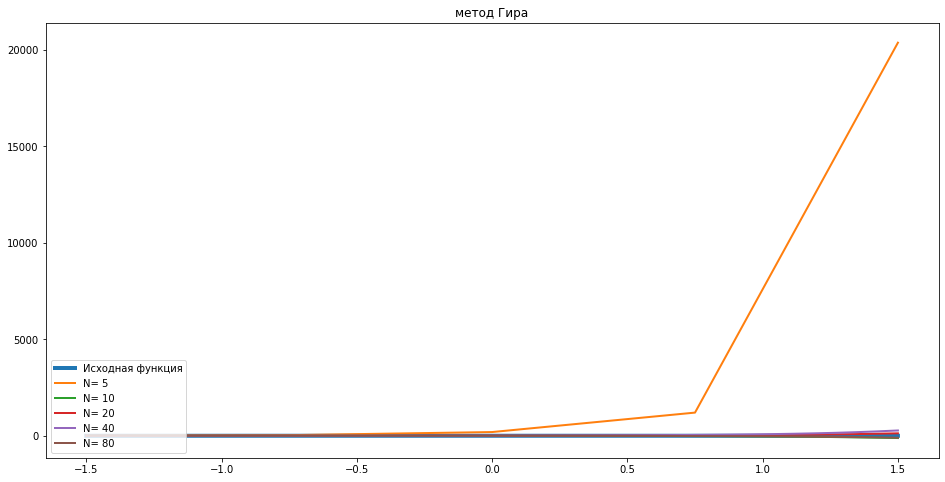

In [46]:
N_start = 5
method = gir_method


fig = plt.figure(figsize=(16,8))
plt.title(method.name)


nodes_draw = np.linspace(method.x0, method.xN, _N)


plt.plot(nodes_draw, fi(nodes_draw), label='Исходная функция', linewidth=4)

    
for i in range(0,5):
    current_n = int(N_start * (2**(i)))
    print(current_n)
    nodes = np.linspace(method.x0, method.xN, current_n)
    
    y = method.calculate(fi(nodes)[:4],f, N = current_n )
    plt.plot(nodes, y, label='N= '+str(current_n), linewidth=2)

plt.legend(loc='lower left')
#plt.show()
plt.savefig(method.name + ".png",dpi = 200)

In [4]:
#Д)

iteration_method = pc_method

N_test = [5 * 2**i for i in range(13,16)]
lambda_test = np.logspace(-7,1,10,endpoint=True)
lambda_test = (1e-2)*lambda_test / lambda_test[-1]

N_examples = len(N_test)
lamda_examples = lambda_test.shape[0]

result = np.zeros((N_examples,lamda_examples))

for N_num in range(N_examples):
    n_cur = N_test[N_num]
    y_fi = fi_method.calculate([],f,N =n_cur)
    print(N_num)
    for lambda_num in range(lamda_examples):
        print("      "+str(lambda_num))
        l_cur = lambda_test[lambda_num]
        iteration_method._lambda = l_cur
        y = iteration_method.calculate([],f, N = n_cur)
        _,_,result[N_num,lambda_num] = compare(y,y_fi)
        
        
r_df = pd.DataFrame(result, index=N_test, columns=lambda_test )
r_df


0
      0
overload 1000
      1
overload 1000
      2
overload 1000


KeyboardInterrupt: 

In [1]:
r_df.to_csv("lambda_test_2.csv")
r_df


NameError: name 'r_df' is not defined

In [ ]:
runge_df = pd.read_csv('runge.csv', header = 0, index_col = 0)
err_df = pd.read_csv('err2.csv', header = 0, index_col = 0)

runge = runge_df.to_numpy()
err = err_df.to_numpy()

(n,m) = runge.shape
result = np.zeros((n,m))

for i in range(n):
    for j in range(m):
        result[i,j] = abs((runge[i,j])/ err[i,j])
result_df = pd.DataFrame(result, index=runge_df.index, columns=runge_df.columns )
result_df.to_csv('runge_vs_err_0.csv')

In [20]:
#Г)

F_norm = 1
max_deltas = np.zeros(17)
method = adams_method
for i in range(17):
    print(i)
    y1 = np.loadtxt('calculations/calc1.%d.out'%i)
    y2 = np.loadtxt('calculations/calc1.%d.out'%(i+1))
    
    max_delta = abs(y1[0] - y2[0])
    for j in range(1,y1.shape[0]):
        max_delta = max ( abs(y1[j] - y2[2*j]),max_delta)
    max_deltas[i] = max_delta
max_deltas = (max_deltas/F_norm) 
r_df = pd.DataFrame(max_deltas, index=[5*(2**i) for i in range(17)], columns=[adams_method.name] ).transpose()
r_df.to_csv("g.csv")
r_df

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


,5,10,20,40,80,160,320,640,1280,2560,5120,10240,20480,40960,81920,163840,327680
явный метод Адамса,5590.124986,1817.234288,2934.56847,127.426892,256.163835,31.023746,2.058223,0.136761,0.02535,0.016161,0.008292,0.004159,0.00208,0.00104,0.00052,0.00026,0.00013
